# Address completeness classification with machine learning techniques
Data & AI course, UC Leuven, 2021 Fall
### Project supervisors
- Tom Magerman
- Aimée Lynn Backiel

### Project team (Group 4)
- Karolis Medekša
- Pedro Teixeira Palma Rosa
- Hysa Mello de Alcântara
- Josep Jacob Chetrit Valdepeñas

## Goals
The goal if the assignment to implement a address classification into complete/incomplete by incorporating machine learning techniques. The workload can be split into three steps:
- extracting data from addresses, that could be used to train an AI model
- training an AI model(s)
- Evaluate the performance and applicability of model(s)

## Preparing training data
Before preparing test data, utility functions for reading/writing excel files are needed:

In [1]:
import pandas as pd

def read_DataFrame_from_file(filename: str, numberOfRows: int = None):
    return pd.read_excel(filename, nrows = numberOfRows, keep_default_na=False)


def write_DataFrame_to_excel(df: pd.DataFrame, filename: str):
    sheet_name = 'Output'

    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=False)

        worksheet = writer.sheets[sheet_name]
        # format all data as a table
        worksheet.add_table(0, 0, df.shape[0], df.shape[1]-1, {
            'columns': [{'header': col_name} for col_name in df.columns],
            'style': 'Table Style Medium 5'
        })
        # Widen the address column
        worksheet.set_column('A:A', 70)

Then, it is possible to extract the following data from each address entry:

Number of characters

In [3]:
def getAddressLength(address: str):
    return len(address)
print(getAddressLength('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

48


Number of digits

In [5]:
import re

def getDigitsCount(address: str):
    return len(re.findall(r'\d', address))
print(getDigitsCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

12


Number of groups of consecutive digits

In [7]:
def getDigitGroupCount(address: str):
    return len(re.findall(r'(\d+)', address))
print(getDigitGroupCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

3


Number of separated digit groups, examples: 1-123, 124 565, 12/27

In [10]:
def getSeparatedDigitGroupCount(address: str):
    return len(re.findall(r'(\d+)[^\d,](\d+)', address))
print(getSeparatedDigitGroupCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

1


Number of space or comma separated tokens

In [11]:
def getTokenCount(address: str):
    return len(re.findall(r'([^\s,]+)', address))
print(getTokenCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

7


Comma count

In [12]:
def getCommaCount(address: str):
    return len(re.findall(r',', address))
print(getCommaCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

2


Number of comma separated substrings, containing a number

In [14]:
def getCommaSeparatedEntityWithNumbersCount(address: str):
    return len(re.findall(r'[^,]*\d+[^,]*', address))
print(getCommaSeparatedEntityWithNumbersCount('8200 116 Avenue S.E.,NewCastle, Washington 98056'))

2


The number of comma separated entities, having a number and a separated word

In [16]:
def getCommaSeparatedEntityWithNumbersNearWordsCount(address: str):
    return len(re.findall(r'([a-zA-Z]{3,})\s(\w+-)?\d+(-\w+)?|(\w+-)?\d+(-\w+)?\s([a-zA-Z]{3,})[^,]*', address))
print(getCommaSeparatedEntityWithNumbersNearWordsCount('8200 116 Avenue S.E.,NewCastle, Washington 98056, NO-420'))

2


### Complete code for preparing the training data

In [21]:
DATA_INPUT_FILENAME = 'raw_data.xlsx'
DATA_OUTPUT_FILENAME = 'training_data.xlsx'
NUMBER_OF_PARSABLE_RECORDS = 999

PROPERTY_LABEL = 'label'
PROPERTY_ADDRESS = 'address'

PROPERTY_LENGTH = 'length'
PROPERTY_DIGITS_COUNT = 'digit_count'
PROPERTY_DIGITS_GROUP_COUNT = 'digits_group_count'
PROPERTY_SEPARATED_DIGIT_GROUP_COUNT = 'separated_digits_group_count'
PROPERTY_TOKEN_COUNT = 'token_count'
PROPERTY_COMMA_COUNT = 'comma_count'
PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS = 'comma_separated_entities_having_numbers'
PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS_NEAR_WORDS = 'comma_separated_entities_having_numbers_near_words'

def assignProperty(dataFrame: pd.DataFrame, property: str, fun: callable):
    dataFrame[property] = dataFrame.apply(lambda row: fun(row[PROPERTY_ADDRESS]), axis=1)


def enrichDataFrameWithProperties(frame: pd.DataFrame):
    assignProperty(frame, PROPERTY_LENGTH, getAddressLength)
    assignProperty(frame, PROPERTY_DIGITS_COUNT, getDigitsCount)
    assignProperty(frame, PROPERTY_DIGITS_GROUP_COUNT, getDigitGroupCount)
    assignProperty(frame, PROPERTY_SEPARATED_DIGIT_GROUP_COUNT, getSeparatedDigitGroupCount)
    assignProperty(frame, PROPERTY_TOKEN_COUNT, getTokenCount)
    assignProperty(frame, PROPERTY_COMMA_COUNT, getCommaCount)
    assignProperty(frame, PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS, getCommaSeparatedEntityWithNumbersCount)
    assignProperty(frame, PROPERTY_COMMA_SEPARATED_ENTITIES_HAVING_DIGITS_NEAR_WORDS, getCommaSeparatedEntityWithNumbersNearWordsCount)


rawData = read_DataFrame_from_file(DATA_INPUT_FILENAME, NUMBER_OF_PARSABLE_RECORDS)

parsedData = pd.DataFrame()
parsedData[PROPERTY_ADDRESS] = rawData['person_address']
enrichDataFrameWithProperties(parsedData)
parsedData[PROPERTY_LABEL] = rawData['label']

write_DataFrame_to_excel(parsedData, DATA_OUTPUT_FILENAME)

An example of prepared training data:
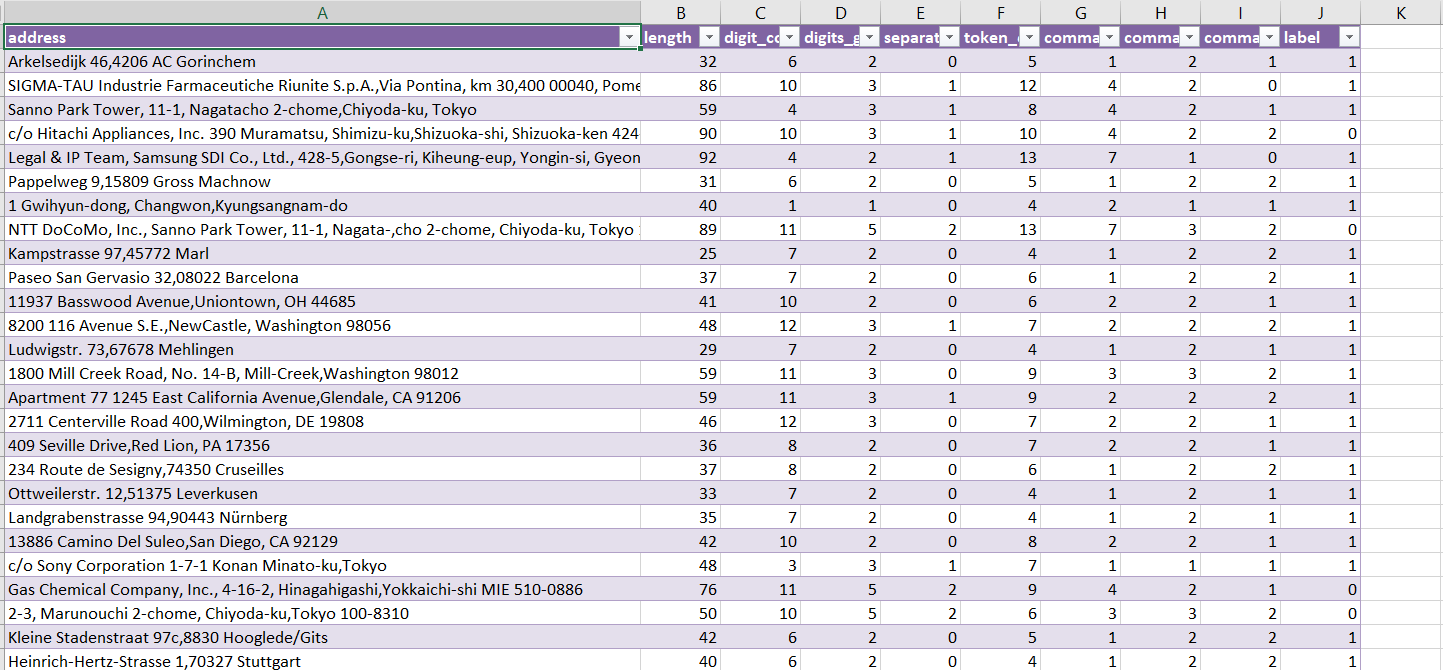